# Introduction

This notebook presents a straightforward way of **training object detection models to identify disc levels** (L1-L2, L2-L3, ..., L5-S1) in Sagittal images.

### Data
- Simple tensor loading from .dcm and resizing to unique shape
- Generates training bounding boxes based on user-defined parameters and X, Y classifications

### Model
- Improved ***Faster R-CNN model with a ResNet-50-FPN backbone*** from [Benchmarking Detection Transfer Learning with Vision Transformers](https://arxiv.org/abs/2111.11429) paper

### Output
- Bounding box location for each disc level
- The final output may be used to:
    - Improve Axial images selection 
    - Feed severity classification models

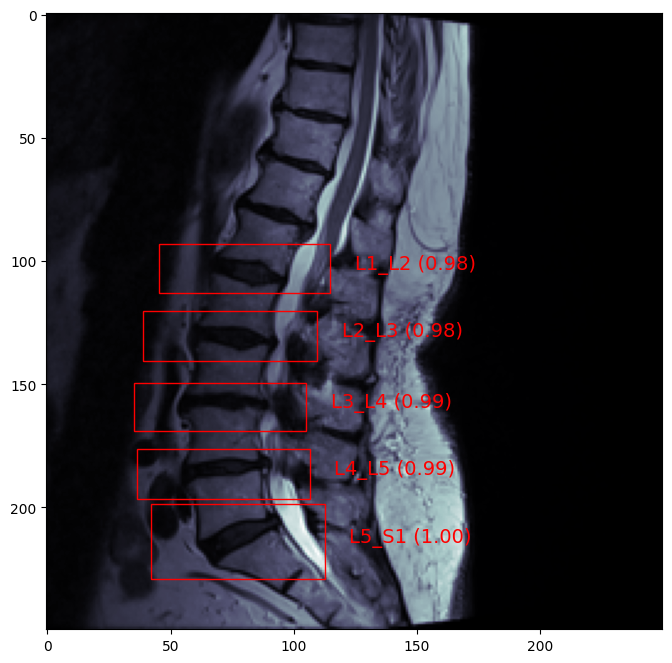

### Next steps
The results are promising, but there is always room for improvement. Feel free to fork this notebook and contribute to its optimization.

**DON'T FORGET TO UPVOTE** if you find this useful :)

# Config

In [25]:
import os
# We will be using these utils provided by PyTorch to simplify training loop code
!pip install -qU pycocotools
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
import utils
from engine import train_one_epoch, evaluate

import re
import itertools
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

import pydicom
from tqdm import tqdm
from PIL import Image
from glob import glob
from pydicom.pixel_data_handlers.util import apply_voi_lut

import torch
import torchvision
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.tv_tensors import BoundingBoxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

--2024-09-13 10:51:24--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py.1'

     0K ...                                                   100% 29.2M=0s

2024-09-13 10:51:24 (29.2 MB/s) - 'engine.py.1' saved [4063/4063]

--2024-09-13 10:51:24--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

In [2]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
MODEL_DIR='/kaggle/working/models'
PRETRAINED_MODEL_FILE = "/kaggle/input/fasterrcnn_resnet50_fpn_v2_colab/pytorch/default/1/model_dict.pt"
CROP_DIR = '/kaggle/working/crops'
DATA_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/"

# 1. Data
## 1.1 Load and transform dataframes

In [4]:
train_df = pd.read_csv(DATA_DIR + "train.csv")
train_lcoord_df = pd.read_csv(DATA_DIR + "train_label_coordinates.csv")
train_sdesc_df = pd.read_csv(DATA_DIR + "train_series_descriptions.csv")

In [5]:
# Map file paths
from glob import glob
study_paths = glob(f"{DATA_DIR}train_images/*")
images_dict = {
    "study_id" : [],
    "series_id" : [],
    "instance_number" : [],
    "image_path": []
}

series_instance_count = {
    "study_id" : [],
    "series_id" : [],
    "instance_count" : []
}
for i, study_path in enumerate(tqdm(study_paths)):
    instance_study_count = 0
    study_id = study_path.split("/")[-1]
    series_paths = glob(f"{study_path}/*")
    for series_path in series_paths:
        instance_count = 0
        series_id = series_path.split("/")[-1]
        instance_paths = glob(f"{series_path}/*")
        for instance_path in instance_paths:
            instance_count+=1
            instance_id = instance_path.split("/")[-1].split(".")[0]

            images_dict["study_id"].append(int(study_id))
            images_dict["series_id"].append(int(series_id))
            images_dict["instance_number"].append(int(instance_id.split(" ")[0]))
            images_dict["image_path"].append(instance_path)

        series_instance_count["study_id"].append(int(study_id))
        series_instance_count["series_id"].append(int(series_id))
        series_instance_count["instance_count"].append(
          instance_count
        )


images_df = pd.DataFrame(images_dict)

100%|██████████| 1975/1975 [00:44<00:00, 44.60it/s]


In [6]:
# Merge to add series description
images_desc_df = pd.merge(images_df,
  train_sdesc_df,
  on=['study_id','series_id']
  )
images_desc_df.head()

# Merge to add condition, level, x, y 
full_train_df = pd.merge(
    train_lcoord_df,
    images_desc_df,
    on=['study_id','series_id', 'instance_number']
)

# Filter Sagittal T2/STIR images
df = full_train_df[(full_train_df['series_description']=='Sagittal T2/STIR')][['study_id', 'series_id', 'instance_number', 'image_path', 'x', 'y', 'level']]

# Drop duplicate levels in every series.
## One (X, Y) per level is enough!
## It will be transported to other instances if necessary with little impact to performance.
df = df.drop_duplicates(subset=['study_id', 'series_id', 'level'])


# Replace L1/L2 format to L1_L2 to prevent path conflict
df['level'] = df['level'].apply(lambda x: x.replace("/", "_"))
df

,study_id,series_id,instance_number,image_path,x,y,level
0,4003253,702807833,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,322.831858,227.964602,L1_L2
1,4003253,702807833,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,320.571429,295.714286,L2_L3
2,4003253,702807833,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,323.030303,371.818182,L3_L4
3,4003253,702807833,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,335.292035,427.327434,L4_L5
4,4003253,702807833,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,353.415929,483.964602,L5_S1
...,...,...,...,...,...,...,...
48667,4290709089,3274612423,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,181.668947,88.864569,L1_L2
48668,4290709089,3274612423,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,174.227086,125.198358,L2_L3
48669,4290709089,3274612423,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,174.227086,160.656635,L3_L4
48670,4290709089,3274612423,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,182.544460,191.299590,L4_L5


## 1.2 PyTorch Dataset

In [7]:
# Load image as tensor
def load_image_from_path(path):
    img = pydicom.dcmread(path)
    img = img.pixel_array
    img = (img - img.min()) / (img.max() - img.min() +1e-6) * 255 # Pixel value between 0-255
    img = tv_tensors.Image(img) # [CHANNEL, HEIGHT, WIDTH]
    return img.double()

In [8]:
# Disc mapping 
DISC_LABELS = {
    "L1_L2": [1],
    "L2_L3": [2],
    "L3_L4": [3],
    "L4_L5": [4],
    "L5_S1": [5]
}

In [9]:
class RSNAMultipleBBoxesDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None, limit=None):
        # Limit for debugging
        if limit:
            df = df.iloc[0:limit]
        
        self.df = df
        
        # Unique image_paths
        self.images_df = df[
          ['study_id', 'series_id', 'instance_number', 'image_path']
        ].drop_duplicates().reset_index(drop=True)


        self.transforms = transforms

    def __getitem__(self, idx):
        image = self.images_df.iloc[idx]
        target = {}

        # Image
        img = load_image_from_path(image['image_path'])
        w_orig, h_orig = img.shape[-1], img.shape[-2]
        target['img'] = img
        target['image_id'] = idx
        target['series_id'] = image['series_id']
        target['study_id'] = image['study_id']
        target['instance_number'] = image['instance_number']

        # Transform
        if self.transforms:
            img = self.transforms(img)

        w_resize, h_resize = img.shape[-1], img.shape[-2]
        w_ratio = w_resize / w_orig
        h_ratio = h_resize/ h_orig


        target['boxes'] = []
        target['area'] = []
        target['labels'] = []
        target['iscrowd'] = []
        series_df = self.df[self.df['series_id'] == image['series_id']]

        for i,row in series_df.iterrows():
            # Label
            target['labels'].append(DISC_LABELS[row['level']])

            # BBox
            ##############################################
            # You can play with this block of code to 
            # modify the bounding box generation.
            if row['level'] == 'L5_S1':
                w = 70
                h = 30
            else:
                w = 70
                h = 20
            # Here, I'm dislocating the box in such a way
            # that upper level discs are closer to the 
            # bottom of it's box and lower level discs 
            # are closer to the top of it's box.
            level = int(row['level'][1])
            x0 = (row['x'])*w_ratio - w*5/6
            x1 = (row['x'])*w_ratio + w*1/6
            y0 = (row['y'])*h_ratio - h*(6-level)/6
            y1 = (row['y'])*h_ratio + h*level/6
            ##############################################

            target['boxes'].append(
              [x0, y0, x1, y1]
            )
            # Box area
            target['area'].append((x1-x0) * (y1-y0))

            # Instances with iscrowd=True will be ignored during evaluation.
            target['iscrowd'].append(False)

        target['area'] = torch.tensor(target['area'])
        target['labels'] = torch.tensor(target['labels']).squeeze(dim=-1)
        target['iscrowd'] = torch.tensor(target['iscrowd'])
        target['boxes'] = BoundingBoxes(
            target['boxes'],
            format='XYXY',
            dtype=torch.float32,
            canvas_size=img.shape[-2:]
        )
        return img, target

    def __len__(self):
        return len(self.images_df)

In [10]:
def get_transform():
    transforms = []
    transforms.append(T.Resize((250, 250), antialias=True))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

## 1.3 PyTorch DataLoader

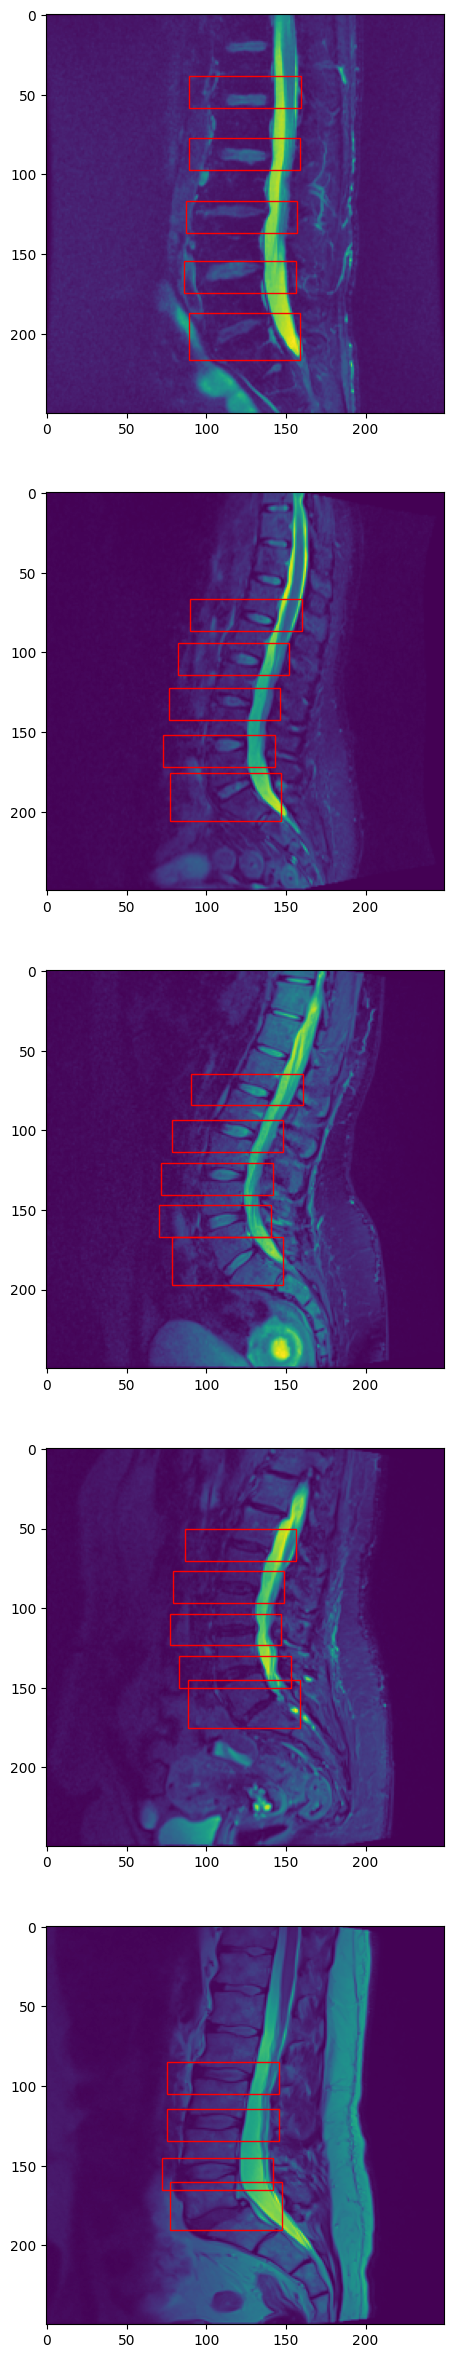

In [11]:
# Trying data loader
tmp_ds = RSNAMultipleBBoxesDataset(df, transforms=get_transform())
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=True,
  collate_fn=utils.collate_fn
)

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(30,30))
for i, (img, t) in enumerate(tmp_dl):
    if i==5:break
    img = img[0]
    t = t[0]
    y = img.squeeze().numpy()
    ax[i].imshow(y)
    for j, box in enumerate(t['boxes']):
        x0, y0, x1, y1 = box.numpy()
        w = x1 - x0
        h = y1 - y0
        ax[i].add_patch(patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none'))
del tmp_ds, tmp_dl

# 2. Model
Reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## 2.1 Config

In [12]:
def get_model_box_predictor(load="latest"):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

    # Replace the classifier with a new one, that has Num_classes
    num_classes = 6  # 5 classes (discs) + background

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if load:
        # Get all matching files
        
        if load =="latest":
            file_pattern = f'{MODEL_DIR}/*/model_dict.pt'
            files = glob(file_pattern)
        elif os.path.isfile(load):
            files = glob(load)
        else:
            files=[]

    # Check if any files were found
    if not files:
        print("Model not found. Creating a new one...")
    else:
        # Get the latest file based on modification time
        latest_file = max(files, key=os.path.getmtime)
        print(f"Loading latest model: {latest_file}")
        model.load_state_dict(torch.load(latest_file))

    return model

In [13]:
model = get_model_box_predictor(load="latest")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 161MB/s]  


Model not found. Creating a new one...


## 2.2 Test forward

In [14]:
# Create dataset and dataloader
dataset = RSNAMultipleBBoxesDataset(df ,get_transform())
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=2,
  shuffle=True,
  collate_fn=utils.collate_fn
)

# Get first input from dataloader
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [15]:
# Inference
model.eval()
with torch.inference_mode():
    predictions = model(images)

In [16]:
# Inspect output
print(predictions[0].keys())
print(predictions[0]['boxes'].shape)  # [100 boxes, 4 dim (x0, y0, x1, y1)]
print(predictions[0]['boxes'][0].tolist()) # (x0, y0, x1, y1) of the first box
print(predictions[0]['labels'][0]) # label of the first box
print(predictions[0]['scores'][0]) # score of the first box

dict_keys(['boxes', 'labels', 'scores'])
torch.Size([100, 4])
[159.5967559814453, 0.0, 160.2945556640625, 174.9573974609375]
tensor(3)
tensor(0.9948)


## 2.3 Training

In [17]:
# use our dataset and defined transformations
train_data, test_data = train_test_split(df, shuffle=False)

dataset = RSNAMultipleBBoxesDataset(train_data ,get_transform())
dataset_test = RSNAMultipleBBoxesDataset(test_data ,get_transform())

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=utils.collate_fn,
    num_workers=os.cpu_count()
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn,
    num_workers=os.cpu_count()
)

model = get_model_box_predictor(load="latest")

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.0001,
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# train it for 3 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    now = datetime.now()
    now = now.strftime("%Y_%m_%d__%H_%M_%S")
    dirname = f'{MODEL_DIR}/{now}'
    os.makedirs(dirname, exist_ok=True,)
    fname = f'{dirname}/model_dict.pt'
    torch.save(model.state_dict(), fname)

Model not found. Creating a new one...
Epoch: [0]  [  0/188]  eta: 0:15:44  lr: 0.000001  loss: 2.1076 (2.1076)  loss_classifier: 1.5502 (1.5502)  loss_box_reg: 0.0738 (0.0738)  loss_objectness: 0.4544 (0.4544)  loss_rpn_box_reg: 0.0292 (0.0292)  time: 5.0257  data: 0.8145  max mem: 12823
Epoch: [0]  [ 10/188]  eta: 0:07:58  lr: 0.000006  loss: 2.0262 (1.9935)  loss_classifier: 1.4790 (1.4465)  loss_box_reg: 0.0925 (0.0927)  loss_objectness: 0.4262 (0.4246)  loss_rpn_box_reg: 0.0292 (0.0297)  time: 2.6867  data: 0.0976  max mem: 13160
Epoch: [0]  [ 20/188]  eta: 0:07:18  lr: 0.000011  loss: 1.7028 (1.6712)  loss_classifier: 1.2014 (1.1928)  loss_box_reg: 0.1412 (0.1453)  loss_objectness: 0.3165 (0.3024)  loss_rpn_box_reg: 0.0302 (0.0307)  time: 2.4870  data: 0.0285  max mem: 13160
Epoch: [0]  [ 30/188]  eta: 0:06:52  lr: 0.000017  loss: 0.9354 (1.3956)  loss_classifier: 0.5960 (0.9618)  loss_box_reg: 0.2365 (0.1824)  loss_objectness: 0.0582 (0.2201)  loss_rpn_box_reg: 0.0325 (0.0313)  

# 3. Output

## 3.1 Validation

In [18]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

def get_best_boxes(pred):
    best_boxes = {}

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if label.item() not in best_boxes or score > best_boxes[label.item()]['score']:
            best_boxes[label.item()] = {'box': box.tolist(), 'score': score.item()}

    result = {
        'boxes': [entry['box'] for entry in best_boxes.values()],
        'labels': list(best_boxes.keys()),
        'scores': [entry['score'] for entry in best_boxes.values()]
    }

    return result

def plot_prediction(x, pred):
    x = x[0, :]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    ax.imshow(x, cmap="bone")
    pred = get_best_boxes(pred)
    for i in range(len(pred['boxes'])):
        x0, y0, x1, y1 = pred['boxes'][i]
        label = pred['labels'][i]
        score = pred['scores'][i]
        h = y1 - y0
        w = x1 - x0
        ax.add_patch(patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none'))
        ax.text(x0+w+10, y0+h/2, f"{LABELS_DICT[label]} ({'{:.2f}'.format(score)})", color='r',fontsize=14)

In [19]:
# Loading my pretrained model (6 epochs)
model = get_model_box_predictor(load=PRETRAINED_MODEL_FILE)

Loading latest model: /kaggle/input/fasterrcnn_resnet50_fpn_v2_colab/pytorch/default/1/model_dict.pt


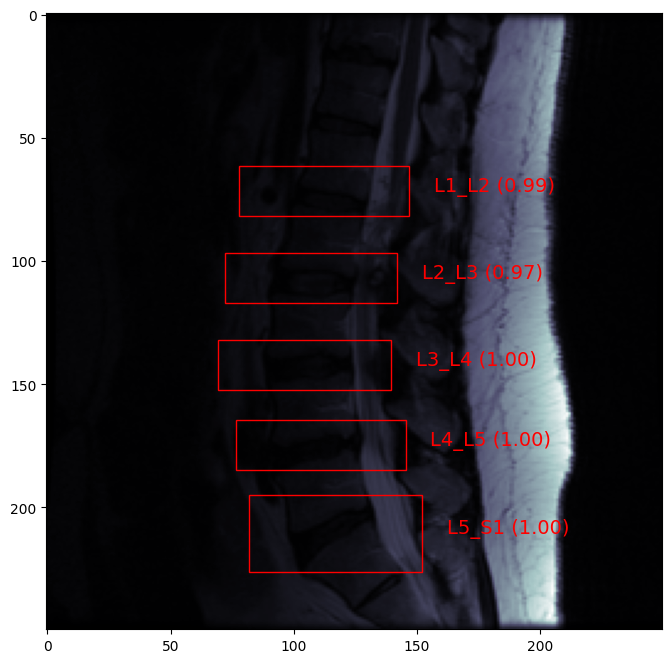

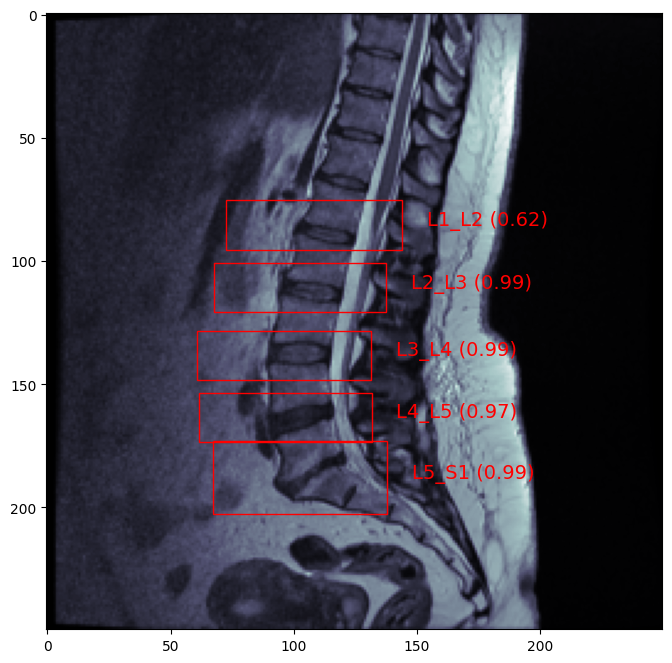

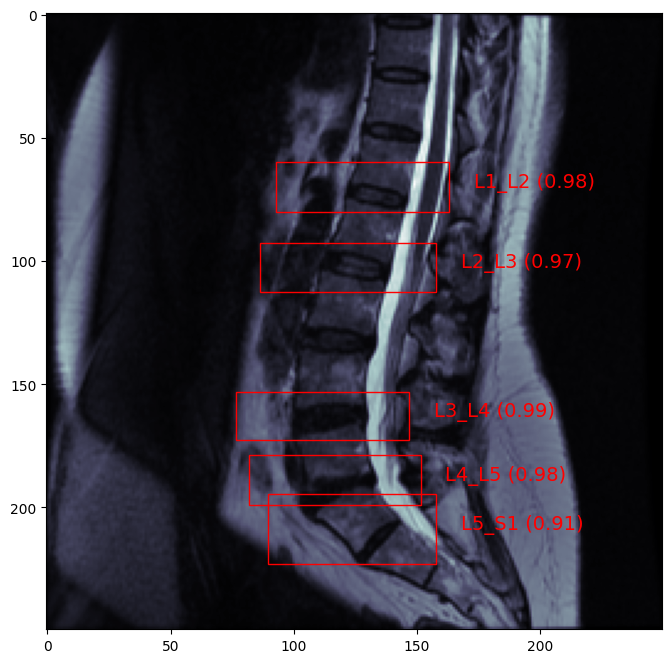

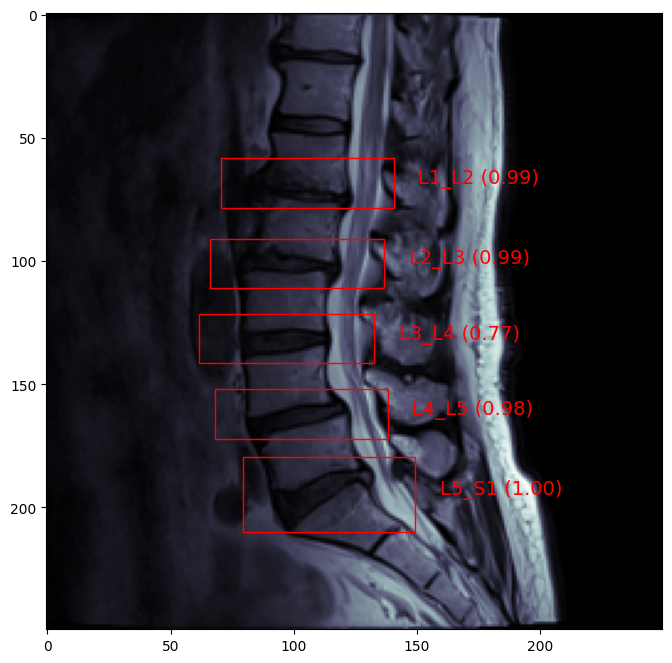

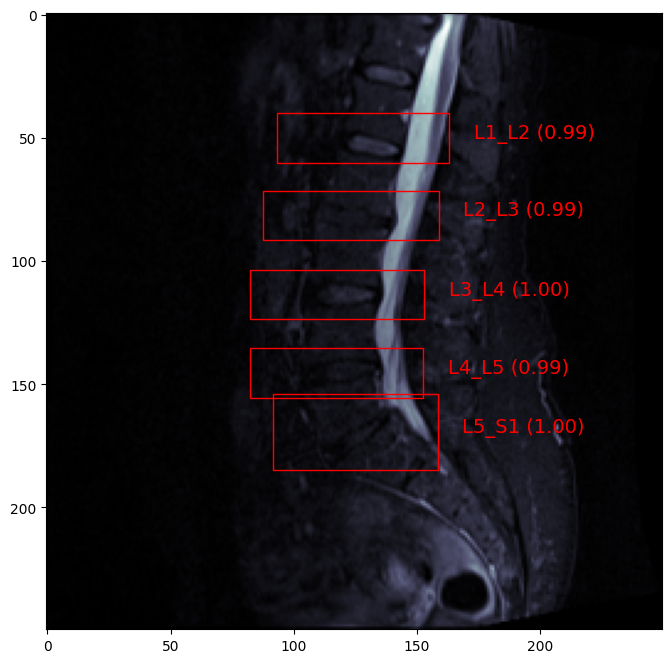

In [20]:
train_data, test_data = train_test_split(df, shuffle=False)
dataset_test = RSNAMultipleBBoxesDataset(test_data, get_transform())

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=5,
    shuffle=False,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader_test))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

model.to(device)
model.eval()
with torch.inference_mode():
    predictions = model(images)

for i in range(len(images)):
    plot_prediction(images[i].cpu(), predictions[i])

## 3.2 Crop Images

In [21]:
def crop_bbox(image, bbox):
    x0, y0, x1, y1 = bbox

    cropped_img = torchvision.transforms.functional.crop(
        image,
        top=round(int(y0)),
        left=round(int(x0)),
        height=round(int(y1 - y0)),
        width=round(int(x1 - x0))
    )
    return cropped_img


def plot_crop(image, bboxes):
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(4,3))
    plt.subplots_adjust(top=2)

    for i in range(len(bboxes['boxes'])):
        label_i = bboxes['labels'][i] - 1
        label = LABELS_DICT[label_i + 1]
        score = bboxes['scores'][i]
        bbox = bboxes['boxes'][i]

        cropped_img = crop_bbox(image, bbox)
        cropped_img = cropped_img[0, :]

        ax[label_i].set_axis_off()
        ax[label_i].imshow(cropped_img, cmap="bone")
        ax[label_i].set_title(f"{label} ({'{:.2f}'.format(score)})")
        

def save_crop(image, bboxes, target):
    series_id = target['series_id']
    study_id = target['study_id']
    instance_number = target['instance_number']


    for i in range(len(bboxes['boxes'])):
        label = LABELS_DICT[bboxes['labels'][i]]

        dirname = f'{CROP_DIR}/train_images/{series_id}/{study_id}/{label}'
        os.makedirs(dirname, exist_ok=True)
        filepath = os.path.join(dirname, f'{instance_number}.pt')

        bbox = bboxes['boxes'][i]

        cropped_img = crop_bbox(image, bbox)
        torch.save(cropped_img, filepath)

    return

In [22]:
LIMIT=5 # Alter limit if needed

dataset = RSNAMultipleBBoxesDataset(df ,get_transform(), limit=LIMIT)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=utils.collate_fn
)

model.eval()
with torch.inference_mode():
    for i, (images, targets) in enumerate(tqdm(data_loader)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        predictions = model(images)

    for i in range(len(images)):
        bboxes = get_best_boxes(predictions[i])
        # plot_prediction(images[i], predictions[i])
        # plot_crop(images[i], bboxes)
        save_crop(images[i].cpu(), bboxes, targets[i])

100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


In [23]:
def load_crop(study_id, series_id, plot=True):
    filepattern = f'{CROP_DIR}/train_images/{study_id}/{series_id}/**/*.pt'
    files = glob(filepattern, recursive=True)
    crops = []
    for file in files:
        crop = torch.load(file)
        crops.append(crop)
        if plot:
            plt.imshow(crop[0], cmap="bone")
            plt.show()
    return crops

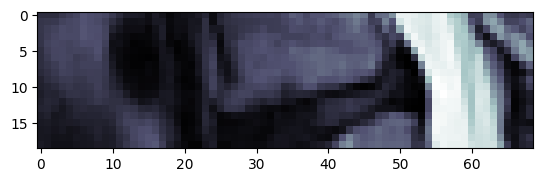

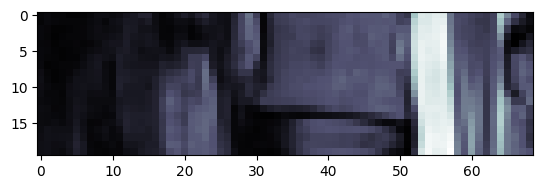

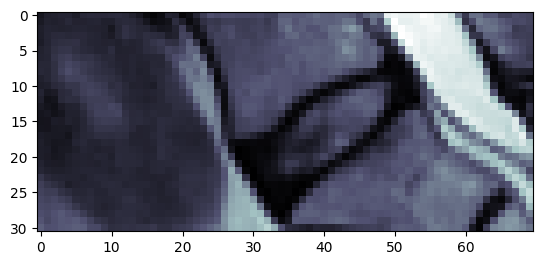

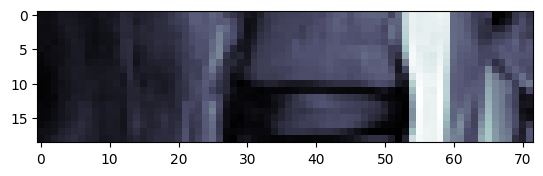

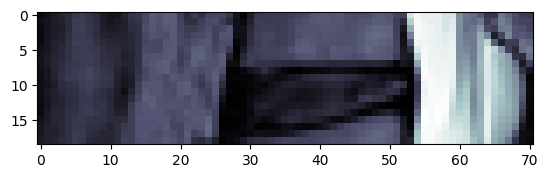

In [24]:
loaded_crops = load_crop(702807833, 4003253)

# 4. Conclusion

I hope this notebook has been helpful. Please leave a comment; it's my first computer vision competition, and I'd love your feedback!